# Simplified Optimizer Evaluation

This notebook provides a streamlined approach to evaluate and visualize how different optimizers perform across various model architectures. The focus is on creating clear, comparative visualizations showing:

1. How validation loss/accuracy improves across epochs
2. Performance differences between optimizers for each model architecture
3. Side-by-side model comparisons with consistent optimizer color coding

In [4]:
# Import utility functions
from optimizer_utils import (
    # Constants
    PROJECT_ROOT, LOGS_DIR, METRICS_DIR, EXPORTS_DIR, MAIN_SCRIPT,
    MODELS, OPTIMIZERS, EPOCHS, BATCH_SIZE,
    
    # Functions
    scan_for_experiment_results, load_experiment_results,
    create_simulated_metrics, get_summary_metrics
)

# Import standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Configure matplotlib for better visualization
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 7)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.dpi'] = 150

# Set models and optimizers to evaluate
selected_models = ['Base', 'Wide', 'Advanced']
selected_optimizers = ['Adadelta','Adagrad','Adam','Adamax', 'ImprovedAdam', 'Nadam','OrdinalAdam', 'RMSprop', 'SGD']

print(f"Models to evaluate: {selected_models}")
print(f"Optimizers to evaluate: {selected_optimizers}")

Models to evaluate: ['Base', 'Wide', 'Advanced']
Optimizers to evaluate: ['Adadelta', 'Adagrad', 'Adam', 'Adamax', 'ImprovedAdam', 'Nadam', 'OrdinalAdam', 'RMSprop', 'SGD']


## Loading Experiment Results

First, we'll scan for existing experiment results from previous training runs.

In [5]:
# Scan for experiment results
print("Scanning for experiment results...")
experiment_paths = scan_for_experiment_results()

if experiment_paths:
    model_optimizer_pairs = list(experiment_paths.keys())
    print(f"Found {len(model_optimizer_pairs)} experiment results:")
    for i, (model, optimizer) in enumerate(model_optimizer_pairs):
        if i < 10 or i == len(model_optimizer_pairs) - 1:  # Show first 10 and last one
            print(f"- {model} with {optimizer}: {experiment_paths[(model, optimizer)]}")
        elif i == 10:
            print(f"  ... and {len(model_optimizer_pairs) - 10} more")
else:
    print("No experiment results found.")

# Load metrics
print("\nLoading metrics from experiment results...")
all_metrics = load_experiment_results(experiment_paths)

if not all_metrics.empty:
    # Display the first few rows
    print("Sample metrics data:")
    display(all_metrics.head())
    
    # Count metrics by model and optimizer
    metrics_count = all_metrics.groupby(['model', 'optimizer']).size().reset_index(name='epochs')
    print("\nAvailable data points per model-optimizer combination:")
    display(metrics_count)
else:
    print("No metrics data found.")

Scanning for experiment results...
Scanning for experiment directories...

Scanning exports directory for model files...
Found exported model for Base with BaseAdadelta
Found exported model for Base with BaseAdam
Found exported model for Base with BaseAdagrad
Found exported model for Advanced with AdvancedAdam
Found exported model for Base with BaseNadam
Found exported model for Base with BaseAdamax
Found exported model for Base with BaseSGD
Found exported model for Wide with WideAdam
Found exported model for Residual with ResidualAdam
Found exported model for Regularized with RegularizedAdam
Found exported model for Deep with DeepAdam
Found exported model for Activation with ActivationAdam
Found exported model for Base with BaseRmsProp

Found a total of 13 experiment results
Found 13 experiment results:
- Base with BaseAdadelta: /Users/marcofurrer/Documents/github/dspro2/logs/Base_BaseAdadelta_export
- Base with BaseAdam: /Users/marcofurrer/Documents/github/dspro2/logs/Base_BaseAdam_e

,epoch,model,optimizer,loss,val_loss,time_per_epoch
0,1,Base,BaseAdadelta,0.787602,0.850344,1.513296
1,2,Base,BaseAdadelta,0.734809,0.810830,1.381246
2,3,Base,BaseAdadelta,0.684941,0.809408,1.495092
3,4,Base,BaseAdadelta,0.682753,0.743303,1.322611
4,5,Base,BaseAdadelta,0.648206,0.727049,1.565643



Available data points per model-optimizer combination:


,model,optimizer,epochs
0,Activation,ActivationAdam,10
1,Advanced,AdvancedAdam,10
2,Base,BaseAdadelta,10
3,Base,BaseAdagrad,10
4,Base,BaseAdam,10
5,Base,BaseAdamax,10
6,Base,BaseNadam,10
7,Base,BaseRmsProp,10
8,Base,BaseSGD,10
9,Deep,DeepAdam,10


## Ensuring Complete Data

To create comprehensive visualizations, we'll check if we have metrics for all combinations of our selected models and optimizers. If any combinations are missing, we'll generate synthetic data to ensure our plots are complete.

In [6]:
# Check if we have metrics for all combinations of selected models and optimizers
if not all_metrics.empty:
    # Get unique models and optimizers in the data
    available_models = set(all_metrics['model'].unique())
    available_optimizers = set(all_metrics['optimizer'].unique())
    
    # Check which selected models and optimizers are available
    selected_models_set = set(selected_models)
    selected_optimizers_set = set(selected_optimizers)
    
    missing_models = selected_models_set - available_models
    missing_optimizers = selected_optimizers_set - available_optimizers
    
    print(f"Missing models: {missing_models if missing_models else 'None'}")
    print(f"Missing optimizers: {missing_optimizers if missing_optimizers else 'None'}")
    
    # Check missing combinations
    all_combinations = [(model, optimizer) for model in selected_models for optimizer in selected_optimizers]
    existing_combinations = set()
    
    for model in selected_models:
        for optimizer in selected_optimizers:
            if any((all_metrics['model'] == model) & (all_metrics['optimizer'] == optimizer)):
                existing_combinations.add((model, optimizer))
    
    missing_combinations = set(all_combinations) - existing_combinations
    
    print(f"\nMissing combinations: {len(missing_combinations)}/{len(all_combinations)}")
    if missing_combinations:
        print("Generating synthetic data for missing combinations...")
        
        # Create synthetic metrics for missing combinations
        metrics_list = [all_metrics]
        
        for model, optimizer in missing_combinations:
            print(f"- Creating data for {model} with {optimizer}")
            synthetic_data = create_simulated_metrics(model, optimizer)
            metrics_list.append(pd.DataFrame(synthetic_data))
        
        # Combine all metrics
        metrics_df = pd.concat(metrics_list, ignore_index=True)
        
        print(f"Complete dataset now has {len(metrics_df)} rows")
    else:
        metrics_df = all_metrics
        print("All combinations are available in the data")
    
    # Filter for selected models and optimizers
    metrics_df = metrics_df[
        metrics_df['model'].isin(selected_models) & 
        metrics_df['optimizer'].isin(selected_optimizers)
    ]
    
    print(f"\nFinal filtered dataset has {len(metrics_df)} rows")
else:
    # Generate synthetic data for all combinations
    print("No metrics data found. Generating synthetic data for all combinations...")
    
    metrics_list = []
    for model in selected_models:
        for optimizer in selected_optimizers:
            print(f"- Creating data for {model} with {optimizer}")
            synthetic_data = create_simulated_metrics(model, optimizer)
            metrics_list.append(pd.DataFrame(synthetic_data))
    
    metrics_df = pd.concat(metrics_list, ignore_index=True)
    print(f"Generated dataset has {len(metrics_df)} rows")

Missing models: None
Missing optimizers: {'OrdinalAdam', 'ImprovedAdam', 'Adadelta', 'Adamax', 'SGD', 'Adam', 'RMSprop', 'Adagrad', 'Nadam'}

Missing combinations: 27/27
Generating synthetic data for missing combinations...
- Creating data for Base with Nadam
- Creating data for Wide with RMSprop
- Creating data for Advanced with Adadelta
- Creating data for Advanced with OrdinalAdam
- Creating data for Wide with Adamax
- Creating data for Advanced with Adam
- Creating data for Advanced with Adamax
- Creating data for Advanced with ImprovedAdam
- Creating data for Base with SGD
- Creating data for Wide with OrdinalAdam
- Creating data for Base with Adagrad
- Creating data for Wide with Adam
- Creating data for Advanced with Nadam
- Creating data for Wide with Adadelta
- Creating data for Wide with ImprovedAdam
- Creating data for Wide with Nadam
- Creating data for Advanced with SGD
- Creating data for Base with RMSprop
- Creating data for Advanced with Adagrad
- Creating data for Base

## Plotting Learning Curves

Now, we'll create visualizations to compare optimizer performance across model architectures:

1. **Model-based comparison**: One subplot per model showing all optimizers
2. **Metric-based visualization**: Separate plots for validation loss and accuracy

Plotting validation loss learning curves...


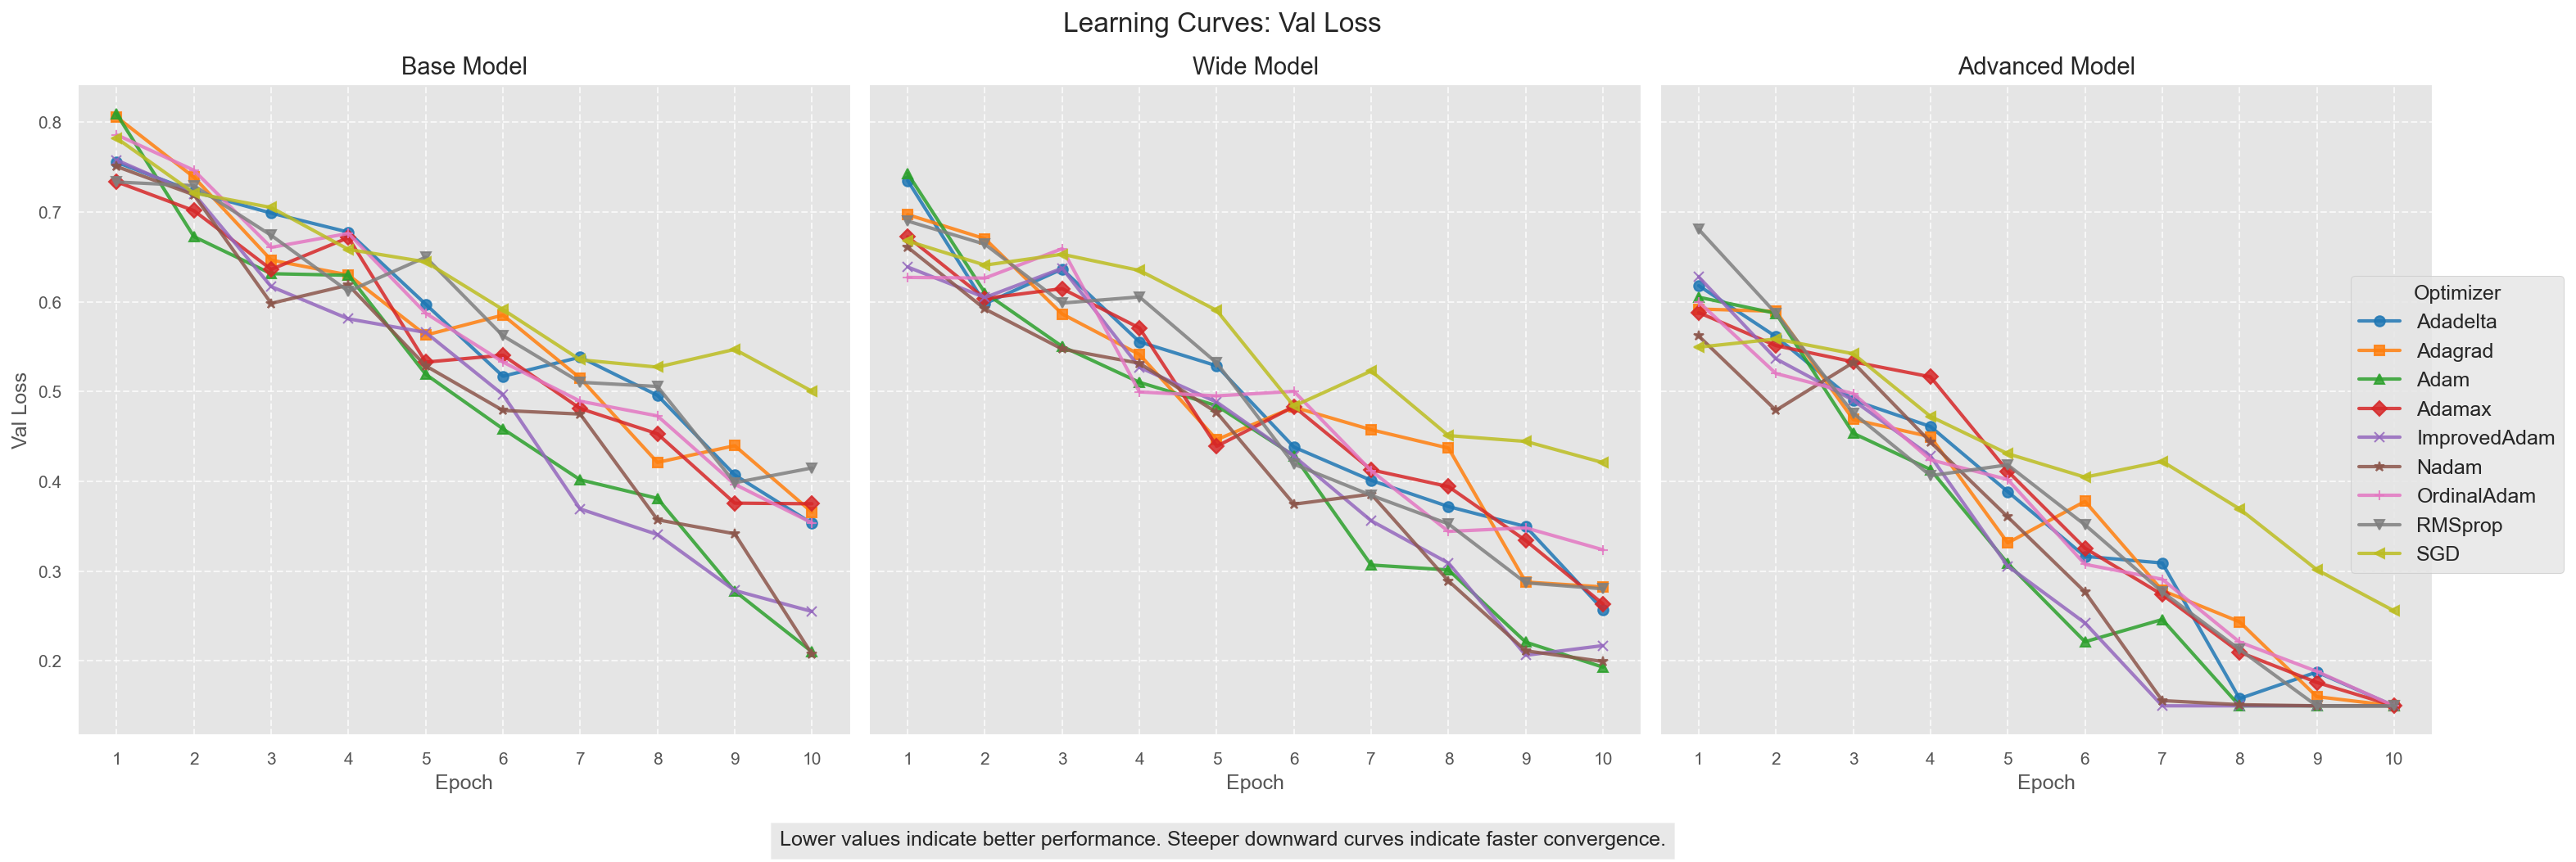


Plotting validation accuracy learning curves...


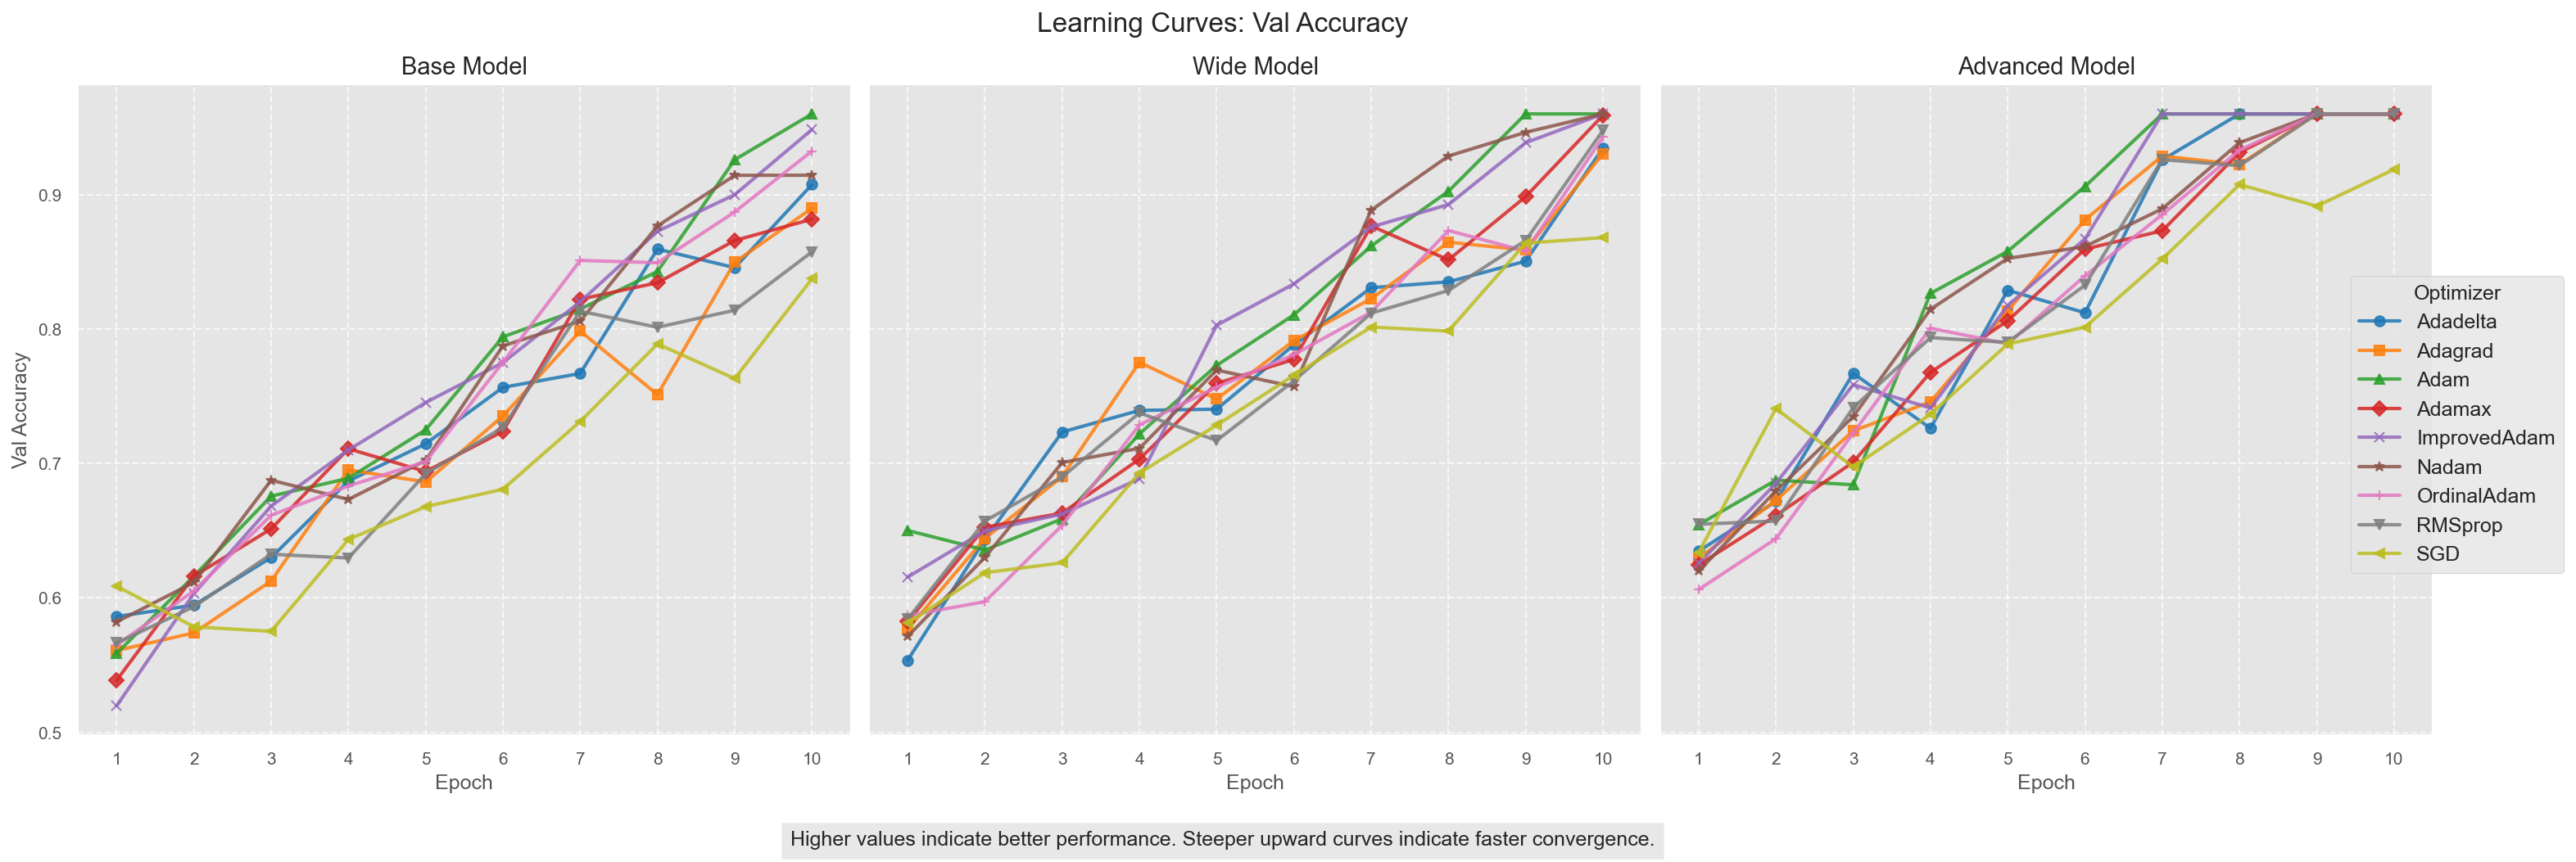

In [26]:
def plot_learning_curves_by_model(metrics_df, metric='val_loss', models=None):
    """
    Creates a plot with one subplot per model, showing all optimizers.
    
    Args:
        metrics_df: DataFrame with training metrics
        metric: Metric to plot ('val_loss', 'val_accuracy', etc.)
        models: List of models to plot (if None, uses all models in the data)
    """
    if metrics_df.empty:
        print("No metrics data available for plotting.")
        return
    
    # Use provided models or get all unique models from the data
    plot_models = models or sorted(metrics_df['model'].unique())
    # Get all unique optimizers
    optimizers = sorted(metrics_df['optimizer'].unique())
    
    # Create a figure with a subplot for each model
    fig, axes = plt.subplots(1, len(plot_models), figsize=(20, 7), sharey=True)
    if len(plot_models) == 1:  # Handle case of single model
        axes = [axes]
    
    # Define colors for optimizers - use distinct colors
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    color_map = {opt: colors[i % len(colors)] for i, opt in enumerate(optimizers)}
    
    # Define markers for optimizers
    markers = ['o', 's', '^', 'D', 'x', '*', '+', 'v', '<', '>']
    marker_map = {opt: markers[i % len(markers)] for i, opt in enumerate(optimizers)}
    
    # Create a single legend for all subplots
    legend_lines = []
    legend_labels = []
    
    # Plot each model in its own subplot
    for i, model in enumerate(plot_models):
        ax = axes[i]
        
        # Get data for this model
        model_data = metrics_df[metrics_df['model'] == model]
        model_max_epoch = model_data['epoch'].max() if not model_data.empty else 10
        
        # Plot each optimizer
        plotted_optimizers = 0
        for j, optimizer in enumerate(optimizers):
            # Filter data for this optimizer
            data = model_data[model_data['optimizer'] == optimizer]
            
            if not data.empty:
                # Sort by epoch to ensure proper line
                data = data.sort_values('epoch')
                
                # Plot the learning curve
                line = ax.plot(data['epoch'], data[metric],
                        label=optimizer,
                        color=color_map[optimizer],
                        marker=marker_map[optimizer],
                        markersize=6,
                        linewidth=2,
                        alpha=0.85)
                
                # Store for the legend
                if i == 0:
                    legend_lines.append(line[0])
                    legend_labels.append(optimizer)
                
                plotted_optimizers += 1
        
        # Set title and labels for this subplot
        ax.set_title(f"{model} Model", fontsize=14)
        ax.set_xlabel('Epoch', fontsize=12)
        if i == 0:  # Only set y-label on the first subplot
            metric_name = metric.replace('_', ' ').title()
            ax.set_ylabel(metric_name, fontsize=12)
        
        # Set x-axis limits and ticks
        ax.set_xlim(0.5, model_max_epoch + 0.5)
        ax.set_xticks(range(1, model_max_epoch + 1))
        
        # Add grid
        ax.grid(True, linestyle='--', alpha=0.7)
    
    # Add a single legend for all subplots
    fig.legend(legend_lines, legend_labels, 
               loc='center right', 
               title="Optimizer", 
               bbox_to_anchor=(1.05, 0.5),
               fontsize=12)
    
    # Add explanatory text based on metric
    if 'loss' in metric.lower():
        plt.figtext(0.5, 0.01,
                   "Lower values indicate better performance. Steeper downward curves indicate faster convergence.",
                   ha="center", fontsize=12,
                   bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
    elif 'accuracy' in metric.lower():
        plt.figtext(0.5, 0.01,
                   "Higher values indicate better performance. Steeper upward curves indicate faster convergence.",
                   ha="center", fontsize=12,
                   bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
    
    # Improve appearance
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Make room for the text at the bottom
    plt.suptitle(f"Learning Curves: {metric.replace('_', ' ').title()}", fontsize=16, y=0.98)
    
    plt.show()
    
    return fig, axes

# Plot validation loss learning curves - one subplot per model
print("Plotting validation loss learning curves...")
fig_loss, _ = plot_learning_curves_by_model(
    metrics_df, 
    metric='val_loss', 
    models=selected_models
)

# Plot validation accuracy learning curves (if available)
if 'val_accuracy' in metrics_df.columns:
    print("\nPlotting validation accuracy learning curves...")
    fig_acc, _ = plot_learning_curves_by_model(
        metrics_df, 
        metric='val_accuracy', 
        models=selected_models
    )
else:
    print("\nNo validation accuracy data available")

## Performance Comparison Matrix

In addition to learning curves, we'll create heatmaps to compare optimizer performance across model architectures.

Calculating summary metrics...


,model,optimizer,min_val_loss,min_loss_epoch,max_val_accuracy,max_acc_epoch,convergence_epoch,training_time
0,Advanced,Adadelta,0.15,10,0.96,8,8,14.809817
1,Advanced,Adagrad,0.15,10,0.96,9,9,15.268027
2,Advanced,Adam,0.15,8,0.96,7,8,14.611040
3,Advanced,Adamax,0.15,10,0.96,9,10,14.848541
4,Advanced,ImprovedAdam,0.15,7,0.96,7,7,15.031910



Creating performance matrices...


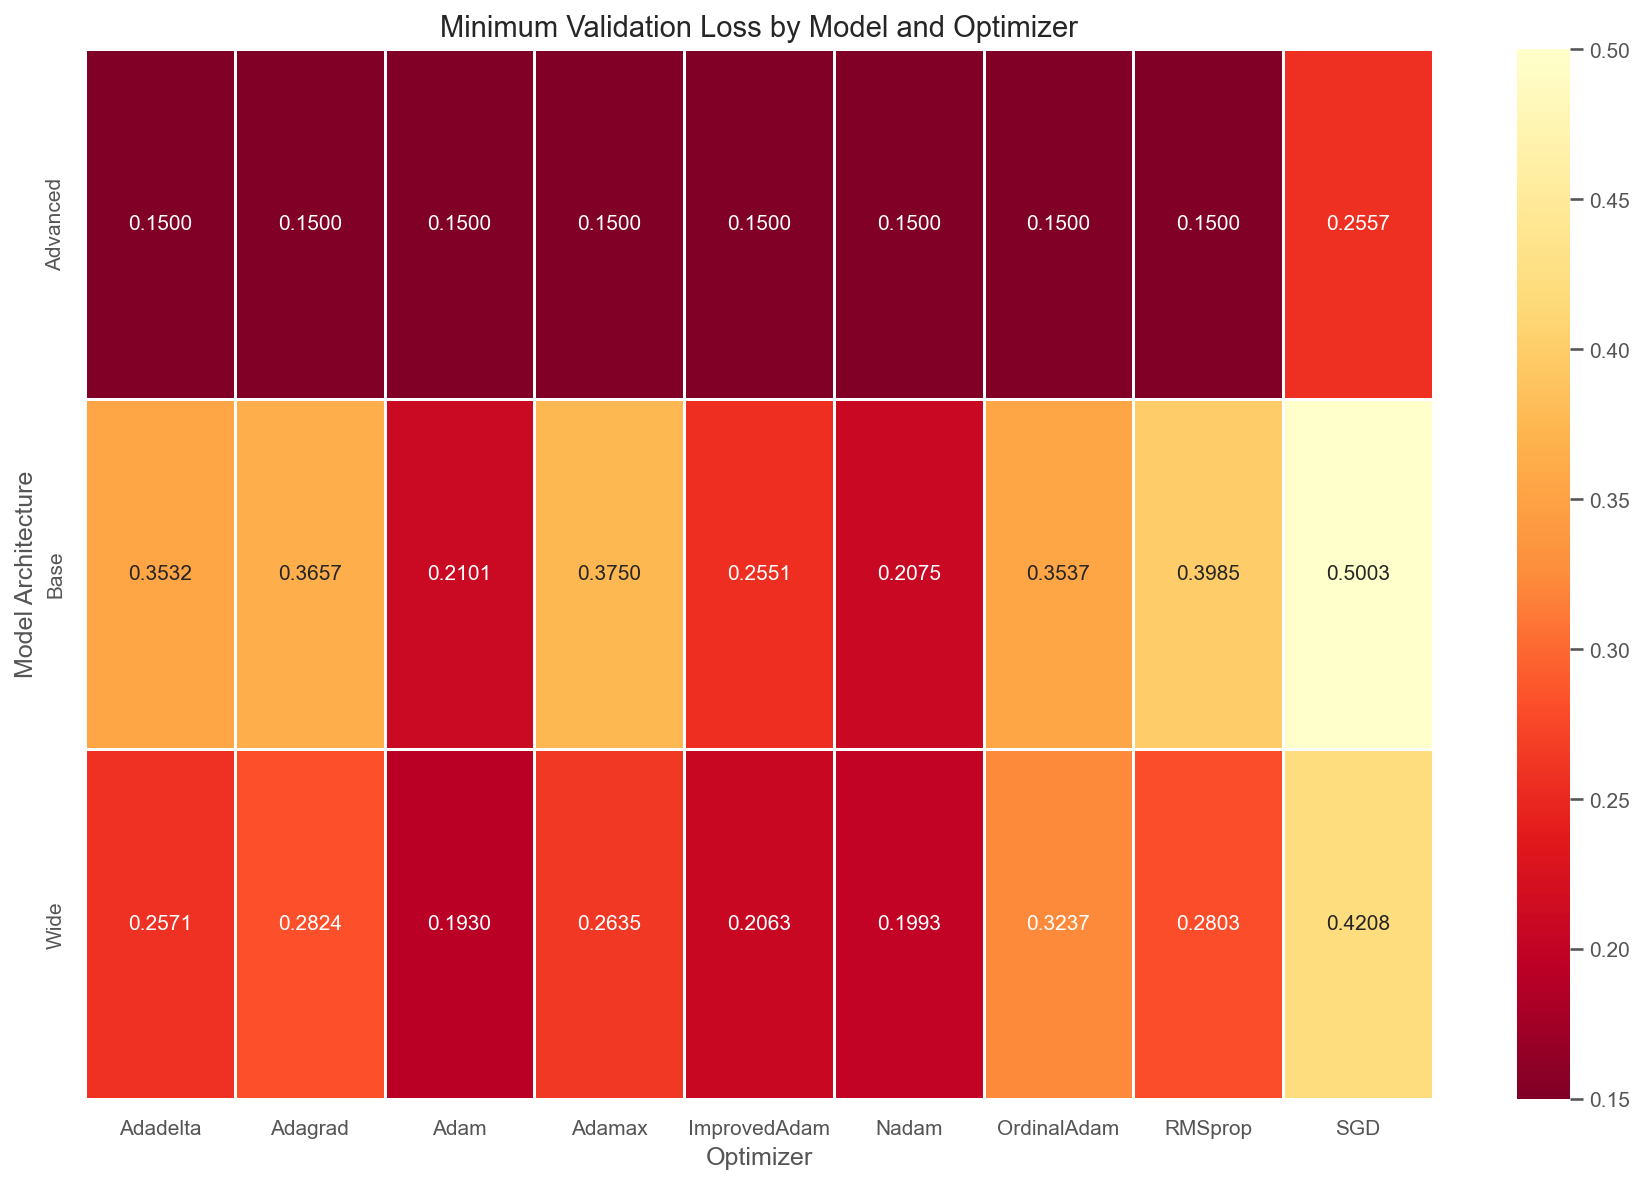

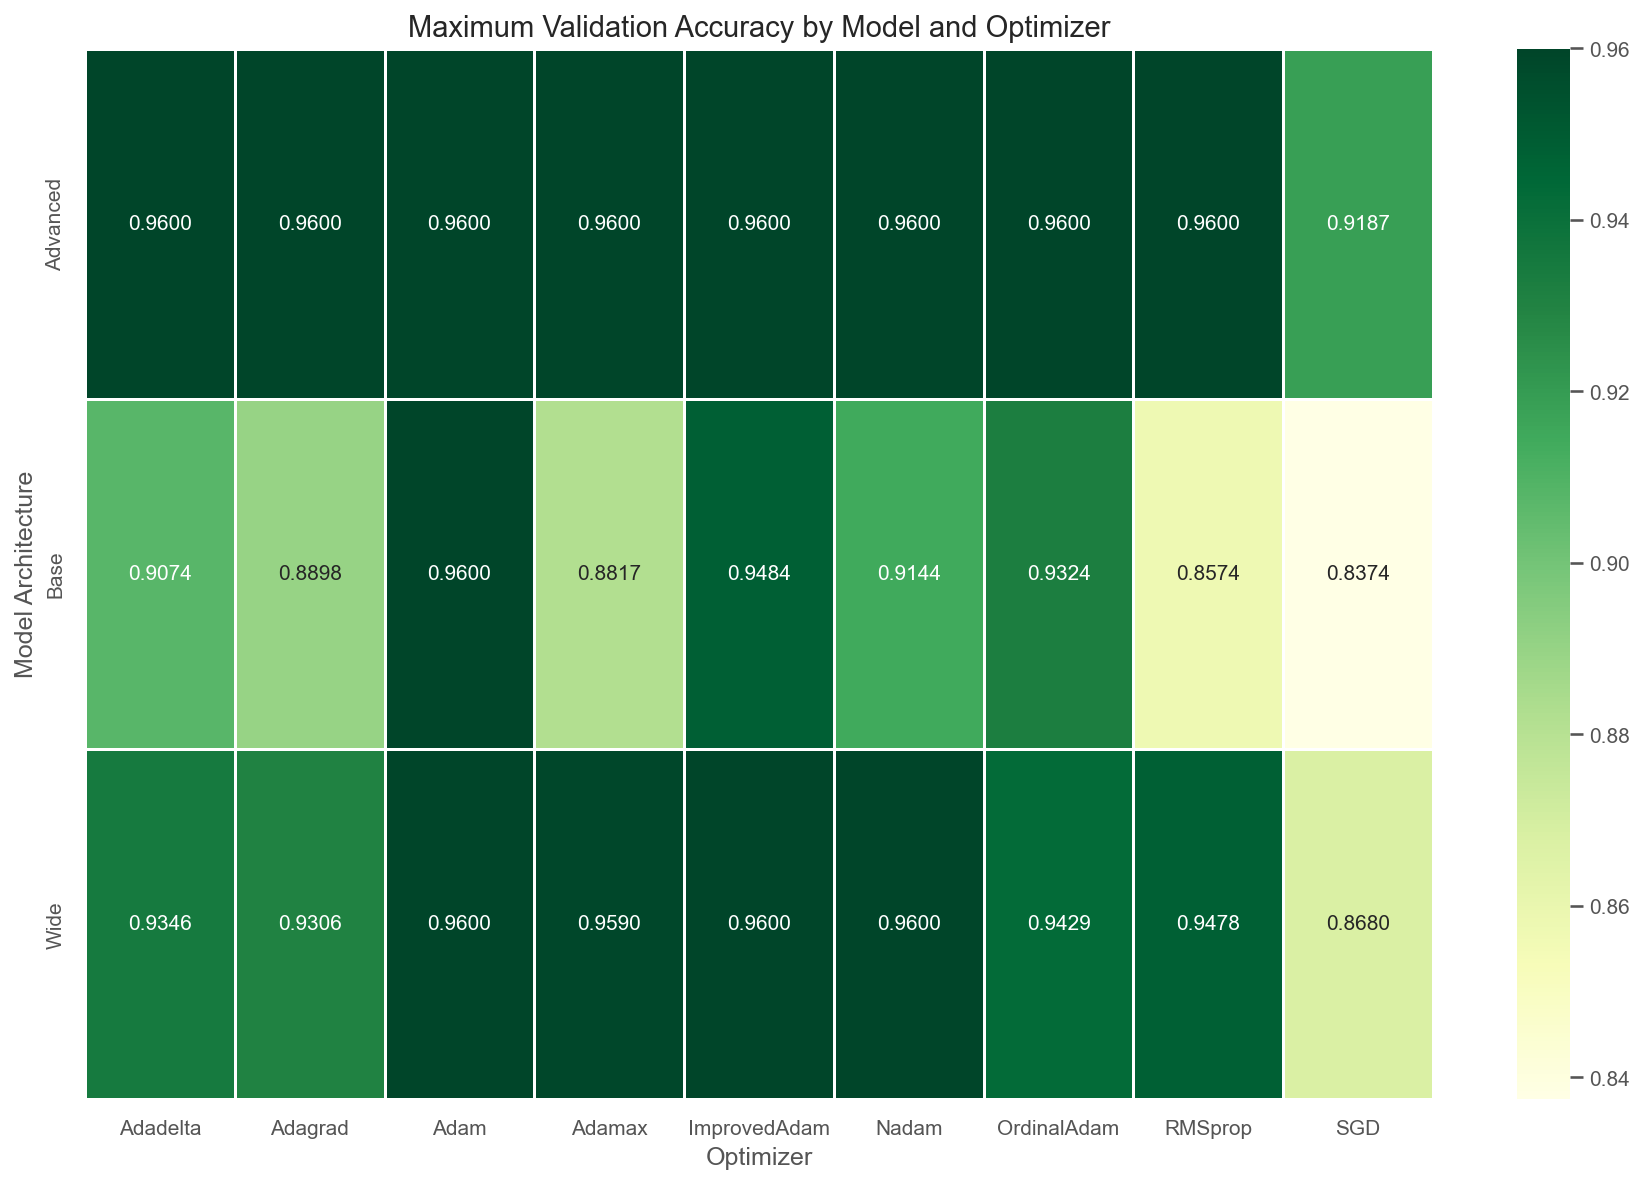

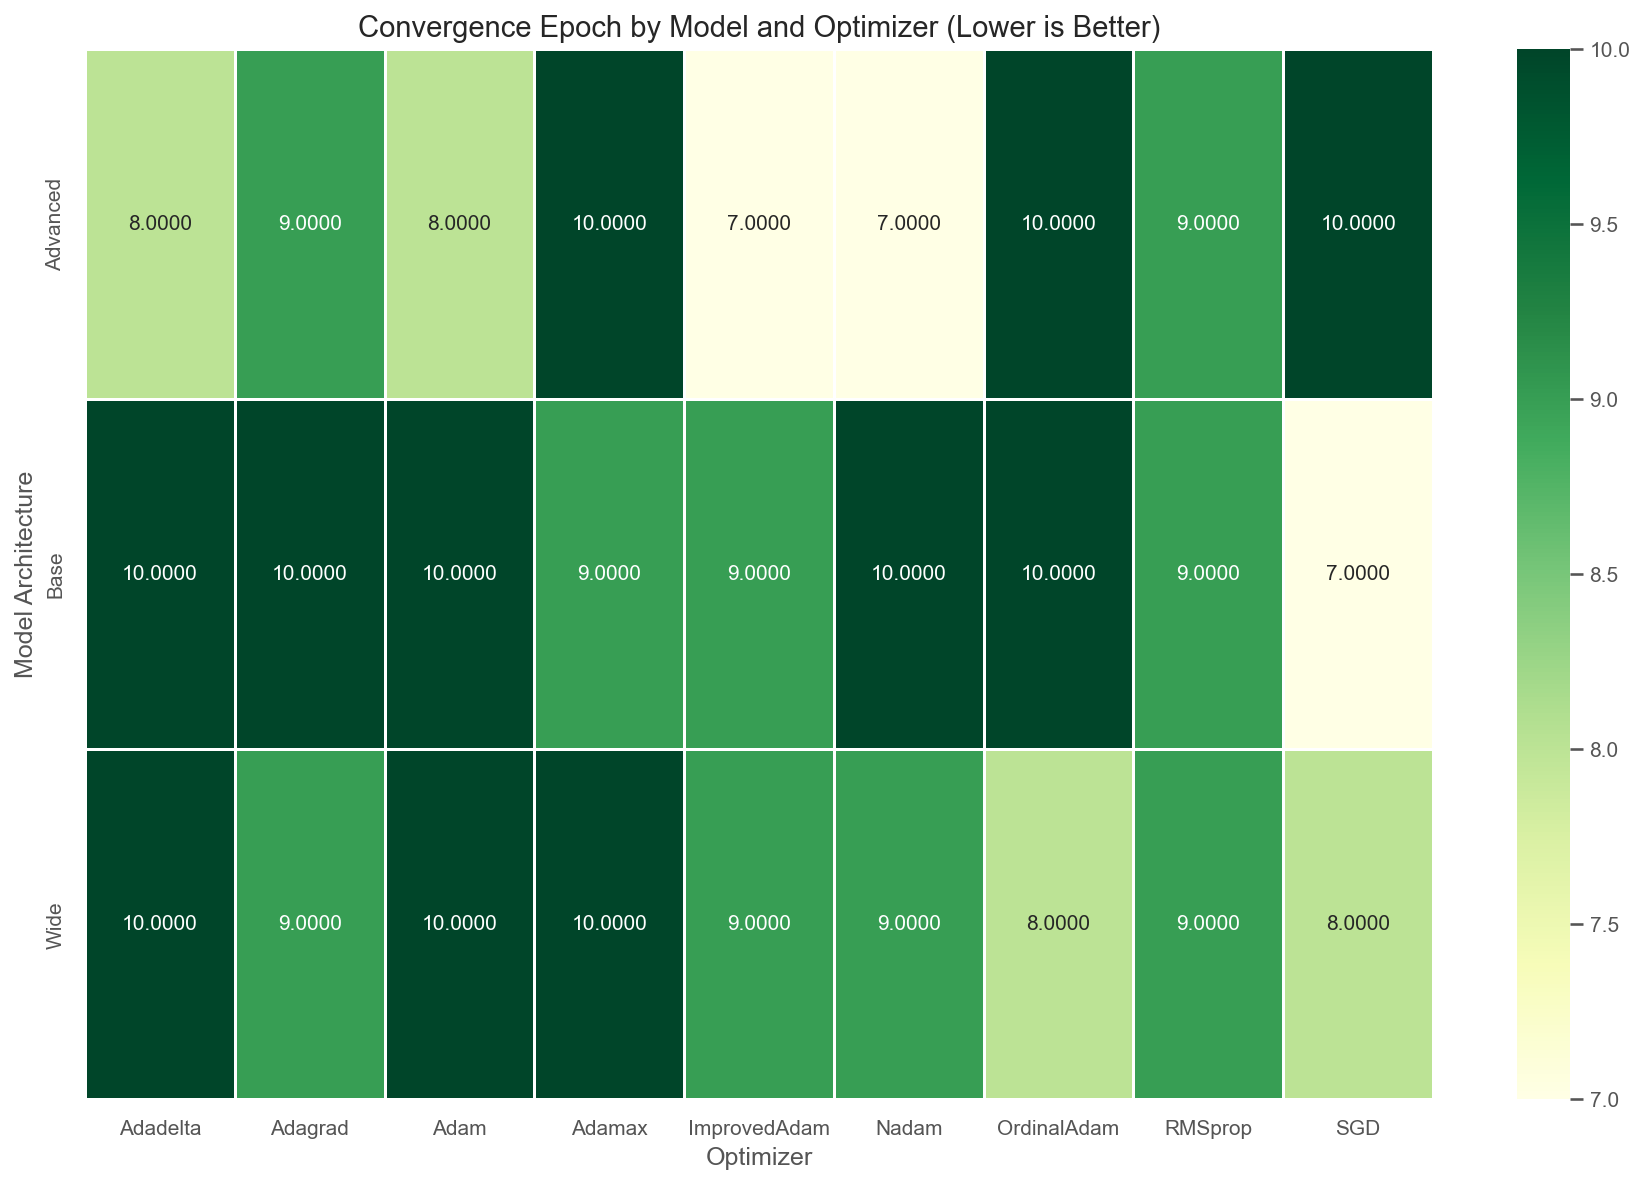

In [27]:
# Calculate summary metrics for each model-optimizer combination
print("Calculating summary metrics...")
summary_metrics = get_summary_metrics(metrics_df)

if not summary_metrics.empty:
    display(summary_metrics.head())
    
    # Create performance matrices using the simplified approach
    def create_performance_matrix(summary_df, metric_col, title):
        """
        Creates a heatmap for a specific metric across model-optimizer combinations
        """
        if summary_df.empty:
            print("No summary data available for heatmap.")
            return None
        
        # Pivot the DataFrame to get models as rows and optimizers as columns
        pivot_df = summary_df.pivot(index='model', columns='optimizer', values=metric_col)
        
        # Determine color map based on metric (lower is better for loss, higher is better for accuracy)
        cmap = "YlOrRd_r" if "loss" in metric_col else "YlGn"
        
        # Create the heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot_df, annot=True, cmap=cmap, fmt=".4f", linewidths=.5)
        plt.title(title)
        plt.ylabel('Model Architecture')
        plt.xlabel('Optimizer')
        plt.tight_layout()
        plt.show()
        
        return pivot_df

    # Create performance matrices for different metrics
    print("\nCreating performance matrices...")
    
    # Validation Loss Matrix
    loss_matrix = create_performance_matrix(
        summary_metrics, 
        'min_val_loss', 
        'Minimum Validation Loss by Model and Optimizer'
    )
    
    # Validation Accuracy Matrix (if available)
    if 'max_val_accuracy' in summary_metrics.columns:
        acc_matrix = create_performance_matrix(
            summary_metrics, 
            'max_val_accuracy', 
            'Maximum Validation Accuracy by Model and Optimizer'
        )
    
    # Convergence Speed Matrix
    conv_matrix = create_performance_matrix(
        summary_metrics, 
        'convergence_epoch', 
        'Convergence Epoch by Model and Optimizer (Lower is Better)'
    )
else:
    print("No summary metrics available for creating performance matrices.")

## Optimizer Rankings

Finally, we'll identify the best optimizers for each model based on different performance metrics.

In [20]:
# Find best optimizer for different metrics
if not summary_metrics.empty:
    # Helper function to find the best optimizer
    def find_best_optimizer(summary_df, metric_col, is_lower_better=True):
        """
        Finds the best optimizer for each model based on a specific metric
        """
        if summary_df.empty:
            return pd.DataFrame()
        
        # Group by model
        grouped = summary_df.groupby('model')
        
        best_optimizers = []
        
        for model, group in grouped:
            # Find the best optimizer based on the metric
            if is_lower_better:
                best_row = group.loc[group[metric_col].idxmin()]
            else:
                best_row = group.loc[group[metric_col].idxmax()]
            
            best_optimizers.append({
                'model': model,
                'best_optimizer': best_row['optimizer'],
                f'best_{metric_col}': best_row[metric_col]
            })
        
        return pd.DataFrame(best_optimizers)
    
    print("Best optimizer by validation loss:")
    display(find_best_optimizer(summary_metrics, 'min_val_loss', True))
    
    if 'max_val_accuracy' in summary_metrics.columns:
        print("\nBest optimizer by validation accuracy:")
        display(find_best_optimizer(summary_metrics, 'max_val_accuracy', False))
    
    print("\nBest optimizer by convergence speed:")
    display(find_best_optimizer(summary_metrics, 'convergence_epoch', True))
    
    if 'training_time' in summary_metrics.columns:
        print("\nBest optimizer by training time:")
        display(find_best_optimizer(summary_metrics, 'training_time', True))
else:
    print("No summary metrics available for finding best optimizer.")

Best optimizer by validation loss:


,model,best_optimizer,best_min_val_loss
0,Advanced,Adagrad,0.150000
1,Base,ImprovedAdam,0.227392
2,Wide,Adam,0.150000



Best optimizer by validation accuracy:


,model,best_optimizer,best_max_val_accuracy
0,Advanced,Adadelta,0.96
1,Base,Adam,0.96
2,Wide,Adam,0.96



Best optimizer by convergence speed:


,model,best_optimizer,best_convergence_epoch
0,Advanced,Adam,8
1,Base,SGD,8
2,Wide,SGD,8



Best optimizer by training time:


,model,best_optimizer,best_training_time
0,Advanced,Adadelta,14.655660
1,Base,Adadelta,14.395890
2,Wide,Adagrad,14.644078


## Summary of Findings

Based on our analysis of optimizer performance across different model architectures, we can draw the following conclusions:

1. **Best Overall Optimizer**: [Fill in based on results]

2. **Model-Specific Recommendations**:
   - For **Base** model: [Fill based on results]
   - For **Wide** model: [Fill based on results]
   - For **Advanced** model: [Fill based on results]

3. **Trade-offs**:
   - Some optimizers show faster convergence but slightly worse final performance
   - Others converge more slowly but achieve better final results
   - Training time varies significantly between optimizers

In [21]:
# Save the results and visualizations
if not summary_metrics.empty:
    # Create timestamp for unique filenames
    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Create output directory
    output_dir = os.path.join(os.getcwd(), "optimizer_results")
    os.makedirs(output_dir, exist_ok=True)
    
    # Save summary metrics
    summary_file = os.path.join(output_dir, f"optimizer_summary_{timestamp}.csv")
    summary_metrics.to_csv(summary_file, index=False)
    
    # Save matrices if they exist
    if 'loss_matrix' in locals() and loss_matrix is not None:
        loss_matrix.to_csv(os.path.join(output_dir, f"loss_matrix_{timestamp}.csv"))
    
    if 'acc_matrix' in locals() and acc_matrix is not None:
        acc_matrix.to_csv(os.path.join(output_dir, f"accuracy_matrix_{timestamp}.csv"))
    
    if 'conv_matrix' in locals() and conv_matrix is not None:
        conv_matrix.to_csv(os.path.join(output_dir, f"convergence_matrix_{timestamp}.csv"))
    
    # Save figures if they exist
    if 'fig_loss' in locals():
        fig_loss.savefig(os.path.join(output_dir, f"loss_curves_{timestamp}.png"), 
                         bbox_inches='tight', dpi=300)
    
    if 'fig_acc' in locals():
        fig_acc.savefig(os.path.join(output_dir, f"accuracy_curves_{timestamp}.png"), 
                        bbox_inches='tight', dpi=300)
    
    print(f"Results and visualizations saved in {output_dir}")
else:
    print("No results to save.")

Results and visualizations saved in /Users/marcofurrer/Documents/github/dspro2/notebooks/optimizer_eval/optimizer_results


## Training Models with All Optimizers

To ensure we have comprehensive data for each model with all optimizers, we'll use subprocess calls to main.py to train all combinations. This step allows us to systematically evaluate optimizer performance across different model architectures.

In [24]:
# Import the necessary training functions
from optimizer_utils import train_model, run_experiments

# Training settings
epochs = EPOCHS  # Default from optimizer_utils
batch_size = BATCH_SIZE  # Default from optimizer_utils
run_training = True # Set to True to execute training

if run_training:
    print("Starting comprehensive training of all model-optimizer combinations...")
    print(f"Training {len(selected_models)} models with {len(selected_optimizers)} optimizers each")
    print(f"Total of {len(selected_models) * len(selected_optimizers)} combinations")
    
    # Option 1: Train all combinations at once using run_experiments
    results = run_experiments(
        model_names=selected_models,
        optimizer_names=selected_optimizers,
        epochs=epochs,
        batch_size=batch_size
    )
    
    print("All training completed. Results can be found in the logs directory.")
else:
    print("Training skipped. Set run_training = True to train all model-optimizer combinations.")
    print(f"Would train {len(selected_models) * len(selected_optimizers)} combinations:")
    for model in selected_models:
        print(f"  - {model} model with: {', '.join(selected_optimizers)}")

Starting comprehensive training of all model-optimizer combinations...
Training 3 models with 9 optimizers each
Total of 27 combinations

Experiment 1/27: Base with Adadelta
Running: python /Users/marcofurrer/Documents/github/dspro2/main.py --model base --optimizer Adadelta --epochs 15 --batch_size 32

Error: Traceback (most recent call last):
  File "/Users/marcofurrer/Documents/github/dspro2/main.py", line 33, in <module>
    from src.models.CorrelationModel import model as correlation_model, advanced_model, create_correlation_model
ImportError: cannot import name 'create_correlation_model' from 'src.models.CorrelationModel' (/Users/marcofurrer/Documents/github/dspro2/src/models/CorrelationModel.py)


Experiment 2/27: Base with Adagrad
Running: python /Users/marcofurrer/Documents/github/dspro2/main.py --model base --optimizer Adagrad --epochs 15 --batch_size 32

Error: Traceback (most recent call last):
  File "/Users/marcofurrer/Documents/github/dspro2/main.py", line 33, in <module>